In [ ]:
# FOR NOW (4/4/25): simplifying code to only work for HAT-P-37 system. 
# XX EXCELLENT occultations of TOI-1518b in TESS Sectors so we should get occ timing too

In [38]:
%matplotlib inline
import lightkurve as lk
import astropy.units as u
import sys
import os
from astropy.time import Time
from astropy.table import Table
from astropy.timeseries import LombScargle
import matplotlib.pyplot as plt
import shutil
from scipy import interpolate
import numpy as np

# sys.path.insert(0, '/Users/era/Documents/GitHub/Doomed-Worlds/project-python-modules/')
# import airmass

###---> True so Brian can run it without my other scripts/output
debug = True  
if debug == False: # running like normal
    from common import *
    from settings import *

In [4]:
# https://docs.lightkurve.org/tutorials/3-science-examples/exoplanets-recover-first-tess-candidate.html

### Get TICs

In [30]:
tess_zero_time = 2457000.
kepler_zero_time = 2454833.

############### Pick planet/mission #################################
use_planet = "HAT-P-37b" # NOTE: TESS data is actually useless due to blended variable star
use_mission = "TESS"
# for now, establish dictionaries of data
tic_id = {} ; known_ref_mid = {} ; known_period = {}
# Other planets NOT in that list, HACK
tic_id["GJ 436b"] = 'TIC 138819293'
tic_id["TIC46432937b"] = 'TIC 46432937'
tic_id["TOI-1855b"] = "TIC 81247740"
tic_id["WASP-45b"] = "TIC 120610833"
tic_id["HAT-P-37b"] = "TIC 267572272" # the precession claim from A-thano 2022

known_ref_mid["HAT-P-37b"] = 2457938.84392#±0.00016
known_period["HAT-P-37b"] = 2.79744256#±0.00000041 Kokori

### Some directories

In [8]:
use_dir = "/Users/rachelhuchmala/HAT-P-37-Transit-Timing-Analysis/code/HAT-P-37b/"

planet_lit_dir = use_dir + "lit-curves/"
if os.path.isdir(planet_lit_dir) == False:
    print("making",planet_lit_dir)
    os.makedirs(planet_lit_dir)
    
output_dir = use_dir + "TESS/"
if os.path.isdir(output_dir) == False:
    print("making",output_dir)
    os.makedirs(output_dir)


### Download light curve sector

In [11]:
### Default
lk.config.get_cache_dir()

'/Users/rachelhuchmala/.lightkurve/cache'

In [12]:
print(tic_id[use_planet])

TIC 267572272


In [3]:
use_raid = True
#https://docs.lightkurve.org/reference/api/lightkurve.config.get_cache_dir.html?highlight=cache#lightkurve.config.get_cache_dir
if use_raid:
    lk.conf.cache_dir = '/Volumes/Pegasus/lightkurve_cache/'
lk.config.get_cache_dir()


/Users/rachelhuchmala/HAT-P-37-Transit-Timing-Analysis/.hat37-env/lib/python3.11/site-packages/lightkurve/config/__init__.py:91: UserWarning: Warning: unable to create /Volumes/Pegasus/lightkurve_cache/ as cache dir  (for downloading MAST files, etc.). Use the current working directory instead.
  warnings.warn(


'/Users/rachelhuchmala/HAT-P-37-Transit-Timing-Analysis/code'

In [4]:
if use_mission == "K2":
    search_result = lk.search_targetpixelfile(epic_id[use_planet], mission=use_mission)
    ### XX need to rewrite to handle kepler/k2 data below --- data probably needs very different conditioning
else:
    search_result = lk.search_targetpixelfile(tic_id[use_planet], mission=use_mission)

In [5]:
#### What sectors are available:
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 26,2020,SPOC,120,267572272,0.0
1,TESS Sector 40,2021,SPOC,120,267572272,0.0
2,TESS Sector 41,2021,SPOC,120,267572272,0.0
3,TESS Sector 53,2022,SPOC,120,267572272,0.0
4,TESS Sector 54,2022,SPOC,120,267572272,0.0
5,TESS Sector 55,2022,SPOC,120,267572272,0.0
6,TESS Sector 59,2022,SPOC,120,267572272,0.0
7,TESS Sector 80,2024,SPOC,20,267572272,0.0
8,TESS Sector 75,2024,SPOC,20,267572272,0.0


In [6]:
### ---> Loook
print_all=False
just_exp="120.0 s"
for ii in range(len(search_result)):
    if print_all:
        print(ii, search_result.mission[ii],search_result.exptime[ii])
    else:
        if search_result.exptime[ii]==just_exp:
            print(ii, search_result.mission[ii],search_result.exptime[ii])


0 TESS Sector 26 120.0 s
1 TESS Sector 40 120.0 s
2 TESS Sector 41 120.0 s
3 TESS Sector 53 120.0 s
4 TESS Sector 54 120.0 s
5 TESS Sector 55 120.0 s
6 TESS Sector 59 120.0 s
11 TESS Sector 80 120.0 s
12 TESS Sector 75 120.0 s
13 TESS Sector 74 120.0 s
14 TESS Sector 82 120.0 s


In [9]:
### To keep track of which ones we've done. Note we do NOT refit ones from Ivshina 2022
## Systems that are currently all up to date with Ivshina:
## "HATS-24b", "HATS-35b"
## "WASP-5b", WASP-18b", WASP-46b","WASP-50b" "WASP-145b", "WASP-164b", "WASP-173b"
good_sectors={}
good_sectors["HAT-P-37b"] = [3,4,5] # Sector 53,54,55


if use_planet in good_sectors.keys():
    print(use_planet, "We have looked at these sectors already:", good_sectors[use_planet])
    
    
### Export sectors for scripting
good_sector_file = use_dir + "TESS/" + "tess_sectors_fit.tsv"
print("Planet\tSector_ids",file=open(good_sector_file,"w"))
for pp in good_sectors.keys():
    if len(good_sectors[pp])>0:
        print("\t".join([pp, str(good_sectors[pp])]),file=open(good_sector_file,"a"))

HAT-P-37b We have looked at these sectors already: [3, 4, 5]


In [79]:
##################################
####### ---> Pick sector ID  #####
### We prefer 120 s (20 s requires too much binning), otherwise shortest available
use_sector_ind = 5
###############

# if runAsPython:
#     use_sector_ind = script_sector_ind
#     print("Script chose sector ind:",use_sector_ind)
##################################

this_tess_sector_name = search_result[use_sector_ind].mission
this_tess_sector_exp = search_result[use_sector_ind].exptime.value[0]
print(this_tess_sector_name,this_tess_sector_exp)
chunk_suffix = str(this_tess_sector_name[0]).replace(" ","-")
print(chunk_suffix)
###

['TESS Sector 55'] 120.0
TESS-Sector-55


In [80]:
# 6 sectors takes ~several minutes, probably mostly the high cadence data
get_all = False
if get_all:
    tpf = search_result.download_all(quality_bitmask='default')
else:
    tpf = search_result[use_sector_ind].download(quality_bitmask='default')
#

/Users/rachelhuchmala/HAT-P-37-Transit-Timing-Analysis/.hat37-env/lib/python3.11/site-packages/lightkurve/config/__init__.py:91: UserWarning: Warning: unable to create /Volumes/Pegasus/lightkurve_cache/ as cache dir  (for downloading MAST files, etc.). Use the current working directory instead.
  warnings.warn(


In [81]:
this_tess_sector_name[0].split(" ")

['TESS', 'Sector', '55']

In [82]:
### Cached file location 
# if the cache problem shows up you can delete
# cd /Volumes/Pegasus/lightkurve_cache/mastDownload/TESS
#  rm -r tess20*305243225*
print(tic_id[use_planet])
cache_dir = "/Volumes/Pegasus/lightkurve_cache/mastDownload/TESS/"

four_digit_sector = "0000"+this_tess_sector_name[0].split(" ")[-1][-4:]
tic_only= tic_id[use_planet].split(" ")[-1]

cache_file_format = "tess20*-s"+four_digit_sector+"-*"+str(tic_only)+"*"

print("IF the cache went bad, type:\n rm -r "+cache_dir+cache_file_format)


TIC 267572272
IF the cache went bad, type:
 rm -r /Volumes/Pegasus/lightkurve_cache/mastDownload/TESS/tess20*-s000055-*267572272*


In [83]:
tpf.meta

OrderedDict([('SIMPLE', True), ('BITPIX', 8), ('NAXIS', 0), ('EXTEND', True), ('NEXTEND', 3), ('EXTNAME', 'PRIMARY'), ('EXTVER', 1), ('SIMDATA', False), ('ORIGIN', 'NASA/Ames'), ('DATE', '2022-09-08'), ('TSTART', 2797.101604985142), ('TSTOP', 2824.265166030834), ('DATE-OBS', '2022-08-05T14:25:09.487'), ('DATE-END', '2022-09-01T18:20:41.161'), ('CREATOR', '63618 TargetPixelExporterPipelineModule'), ('PROCVER', 'spoc-5.0.74-20220814'), ('FILEVER', '1.0'), ('TIMVERSN', 'OGIP/93-003'), ('TELESCOP', 'TESS'), ('INSTRUME', 'TESS Photometer'), ('DATA_REL', 79), ('OBJECT', 'TIC 267572272'), ('TICID', 267572272), ('SECTOR', 55), ('CAMERA', 3), ('CCD', 4), ('PXTABLE', 369), ('RADESYS', 'ICRS'), ('RA_OBJ', 284.296067601648), ('DEC_OBJ', 51.2691248775596), ('EQUINOX', 2000.0), ('PMRA', -4.11372), ('PMDEC', -0.854376), ('PMTOTAL', 4.20150575), ('TESSMAG', 12.76780033), ('TEFF', 5477.0), ('LOGG', 4.54393005), ('MH', None), ('RADIUS', 0.86736798), ('TICVER', '8.2'), ('CRMITEN', True), ('CRBLKSZ', 10),

## Access data

In [84]:
print(use_planet, use_sector_ind)

HAT-P-37b 5


In [85]:
# on 12/5/23 this became necessary:
# ERROR:bokeh.server.views.ws:Refusing websocket connection from Origin 'http://localhost:8889';                       use --allow-websocket-origin=localhost:8889 or set BOKEH_ALLOW_WS_ORIGIN=localhost:8889 to permit this; currently we allow origins {'localhost:8888'}
# WARNING:tornado.access:403 GET /ws (::1) 0.64ms
# WARNING:tornado.access:403 GET /ws (::1) 0.64ms
# lc = tpf.to_lightcurve().remove_outliers(6)
# os.environ["BOKEH_ALLOW_WS_ORIGIN"] = 'localhost:8889' # may need to swap order
os.environ["BOKEH_ALLOW_WS_ORIGIN"] = 'localhost:8888' # may need to swap order
os.environ["BOKEH_ALLOW_WS_ORIGIN"] = '09stgk50ejj1hrqbelni0hhb1t8u7g3qbti9a5837s0aqdtqlpf0'


In [86]:
outlier_threshhold = 6
lc = tpf.to_lightcurve().remove_outliers(outlier_threshhold)

In [87]:
print("First time:",min(lc.time)+tess_zero_time)

First time: 2459797.1022993075


<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

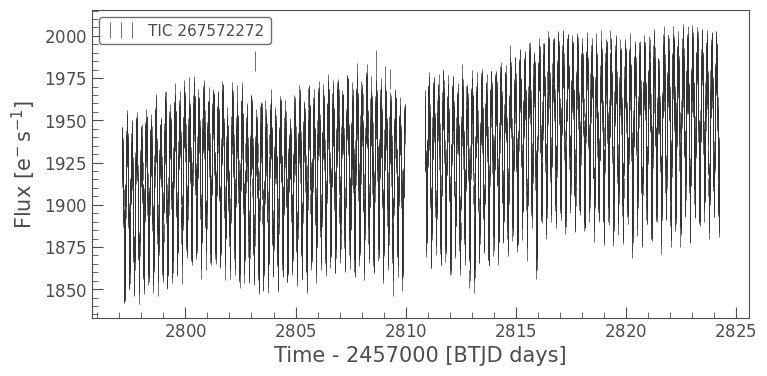

In [88]:
lc.errorbar()

### Mask out (a)  bad zones and (b) transits in the smoothing function

In [89]:
print(use_planet, use_sector_ind)

HAT-P-37b 5


In [90]:
#### ----> Bad regions to mask out, almost always around data gaps
mask_regions={}
mask_regions[use_sector_ind] = None# default
## Inspected by hand
## We get rid of everything between the times in brackets
if use_planet == "HAT-P-37b":
    mask_regions[0] = [[2756,2757]] # example!! do not use!


In [91]:
print(use_planet, use_sector_ind, mask_regions[use_sector_ind])

HAT-P-37b 5 None


In [92]:
if mask_regions[use_sector_ind]  == None:
    masked_lc = lc
else:
    print("masking out these regions:",mask_regions[use_sector_ind])
    masks = []
    for ii in range(len(mask_regions[use_sector_ind])): ## allows for multiple regions to be masked
        bad_t_start = mask_regions[use_sector_ind][ii][0]
        bad_t_end = mask_regions[use_sector_ind][ii][1]
        masks.append( (lc.time.value < bad_t_start) | (lc.time.value > bad_t_end) )
    master_mask = (lc.time == lc.time) # all True to start
    for jj in range(len(masks)):
        master_mask = master_mask & masks[jj]
        print("Masking sector:",jj, "Total points",len(lc.time),"Valid points",list(masks[jj]).count(True))
    print("Master valid points:",list(master_mask).count(True))
    masked_lc = lc[master_mask]


In [75]:
known_period[use_planet]

2.79744256

In [93]:
# https://github.com/lightkurve/lightkurve/issues/327
# https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.create_transit_mask.html

known_transit_mask = masked_lc.create_transit_mask(transit_time=known_ref_mid[use_planet], 
                                                   period=known_period[use_planet],
                                                   duration=0.1)
not_transit_mask = known_transit_mask == False

mask_out_known_to_flatten_lc = masked_lc[not_transit_mask]

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

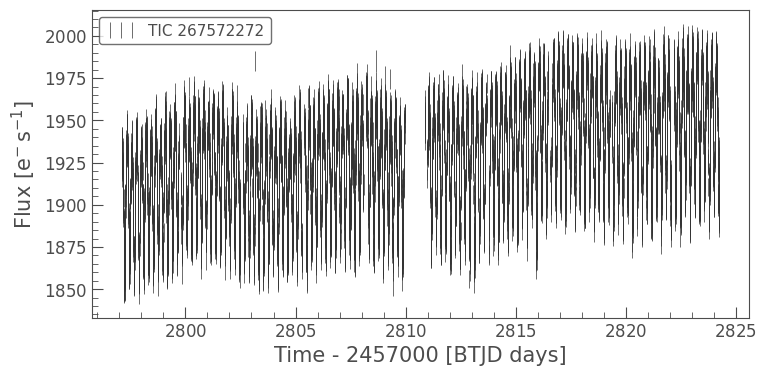

In [94]:
mask_out_known_to_flatten_lc.errorbar()

### Output UNFLATTED but MASKED data (if, say, want to study stellar noise)

In [95]:
## ---> come here
data_file = output_dir + "folded_before_smoothing_"+use_planet+"_"+chunk_suffix+".tsv"
print(data_file)
print("BTJD, Flux, Flux_err",file=open(data_file,"w"))

norm_by = np.median( mask_out_known_to_flatten_lc.flux.value)
print("Normalize by",norm_by)
for ii in range(len(mask_out_known_to_flatten_lc)):
    print(mask_out_known_to_flatten_lc.time[ii],",",mask_out_known_to_flatten_lc.flux[ii].value / norm_by,
          ",",mask_out_known_to_flatten_lc.flux_err[ii].value / norm_by,
         file=open(data_file,"a"))

/Users/rachelhuchmala/HAT-P-37-Transit-Timing-Analysis/code/HAT-P-37b/TESS/folded_before_smoothing_HAT-P-37b_TESS-Sector-55.tsv
Normalize by 1932.673


STOP HERE FOR NOW!

### What if I don't smooth it...???

Best known period for planet: HAT-P-37b 2.79744256


<Axes: xlabel='Period [$\\mathrm{d}$]', ylabel='BLS Power'>

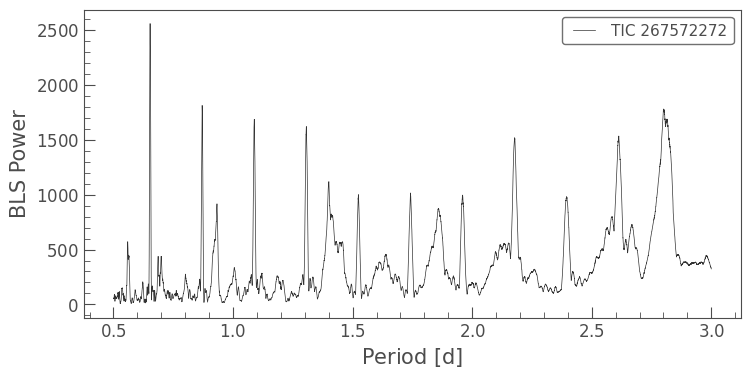

In [39]:
period_grid = np.linspace(0.5, 3, 10000)
print("Best known period for planet:",use_planet,known_period[use_planet])
bls = masked_lc.to_periodogram(method='bls', period=period_grid, frequency_factor=500);
bls.plot()


/Users/rachelhuchmala/HAT-P-37-Transit-Timing-Analysis/code/HAT-P-37b/TESS/folded_before_smoothing_HAT-P-37b_TESS-Sector-53.png


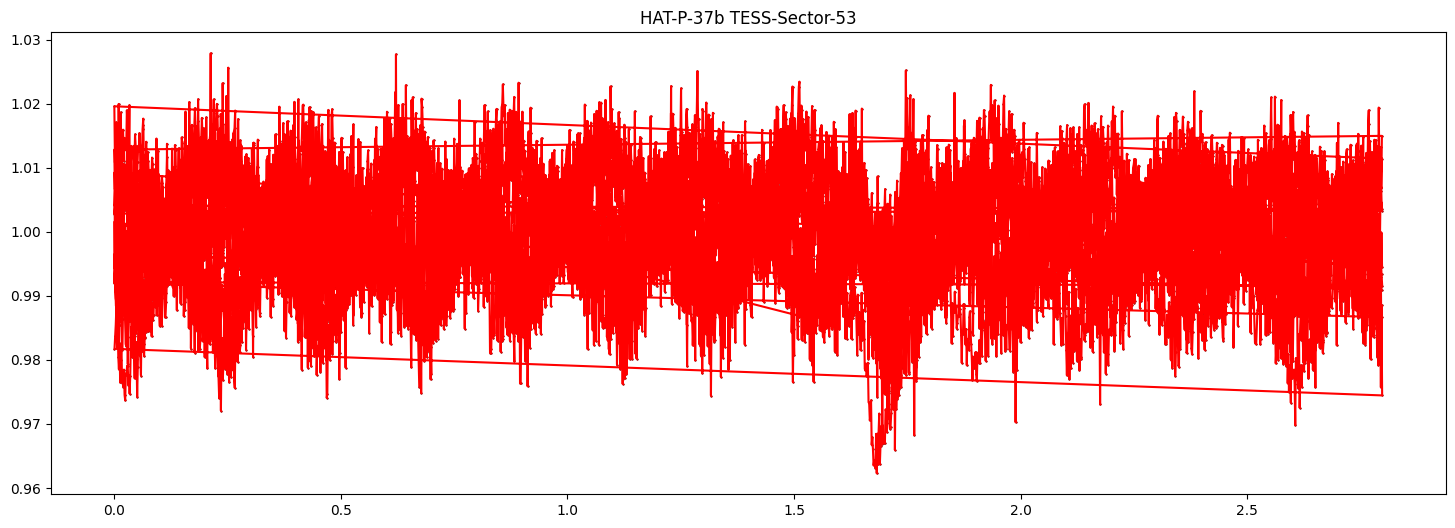

In [40]:
unsmoothed_time = masked_lc.time.value
phased_unsmoothed_time = unsmoothed_time % known_period[use_planet]
phased_unsmoothed_flux_norm =  masked_lc.flux.value / np.median( masked_lc.flux.value)

# bin_t, bin_f, bin_err = get_binned_flux_for_transit(phased_unsmoothed_time, phased_unsmoothed_flux_norm, nb=400,verbose=False)

plot_file = output_dir + "folded_before_smoothing_"+use_planet+"_"+chunk_suffix+".png"
fig=plt.figure(figsize=(18,6),facecolor='white')
plt.errorbar(phased_unsmoothed_time,phased_unsmoothed_flux_norm, yerr= None,
             ls="", color="k", marker='.',markersize=1);
plt.errorbar(phased_unsmoothed_time,phased_unsmoothed_flux_norm, yerr= None,
             ls="-", color="r", marker='.',markersize=1);
plt.title(use_planet+" "+chunk_suffix)
plt.savefig(plot_file, dpi=150, bbox_inches='tight')
print(plot_file)

/Users/rachelhuchmala/HAT-P-37-Transit-Timing-Analysis/code/HAT-P-37b/TESS/folded_before_smoothing_zoomed_HAT-P-37b_TESS-Sector-53.png


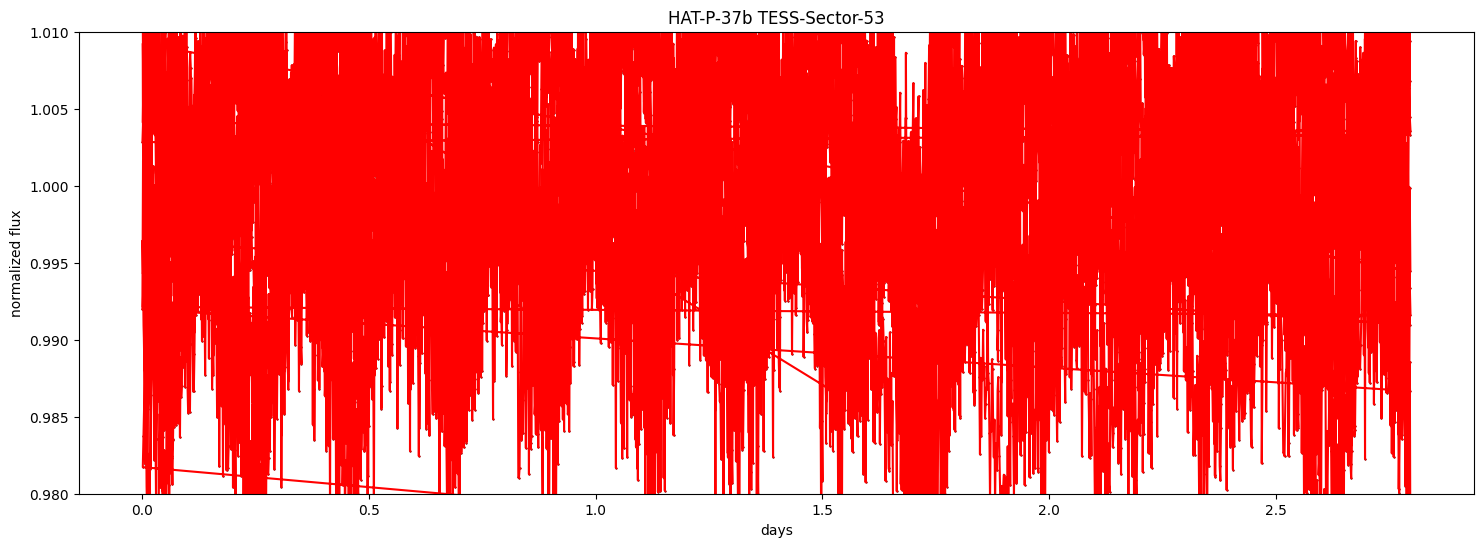

In [41]:
plot_file = output_dir + "folded_before_smoothing_zoomed_"+use_planet+"_"+chunk_suffix+".png"
fig=plt.figure(figsize=(18,6),facecolor='white')
plt.errorbar(phased_unsmoothed_time, phased_unsmoothed_flux_norm, yerr= None,
             ls="", color="k", marker='.',markersize=1);

plt.errorbar(phased_unsmoothed_time,phased_unsmoothed_flux_norm, yerr= None,
             ls="-", color="r", marker='.',markersize=1);

plt.title(use_planet+" "+chunk_suffix)
plt.ylim(0.98,1.01)
plt.xlabel("days")
plt.ylabel("normalized flux")
plt.savefig(plot_file, dpi=150, bbox_inches='tight')
print(plot_file)

### Now smooth the transit (and bad region) masked data

In [53]:
print(use_planet,use_sector_ind)

HAT-P-37b 21


In [54]:
##### ---> Do we need a different window for smoothing?
windows={}
windows["CoRoT-2b",0] = 51 # anything higher than 501 and you get weirdness
windows["CoRoT-21b",0] = 501 
windows["CoRoT-21b",3] = 501 
windows["CoRoT-14b",0] = 2001 
windows["CoRoT-14b",3] = 2001 
windows["GPX-1b",0] = 501 # 
windows["HATS-9b",0] = 251  ## k2 data, very strong stellar variability
windows["HAT-P-23b",0] = 251 
windows["HAT-P-23b",2] = 251 
windows["HAT-P-37b",2] = 251 
windows["HIP-65Ab",0] = 51 
windows["HIP-65Ab",2] = 51 
windows["HIP-65Ab",5] = 51 
windows["HIP-65Ab",8] = 51 
windows["Qatar-10b",1] = 201
windows["NGTS-1b",1] = 301
windows["NGTS-1b",5] = 501
windows["NGTS-6b",3] = 201
windows["TIC46432937b",0] = 21 # good!
windows["TIC46432937b",1] = 51 # good!
windows["TOI-674b",0] = 501 # good!
windows["TOI-674b",2] = 501 # good!
windows["TOI-674b",4] = 501 # good!
windows["TOI-674b",6] = 501 # good!
windows["TOI-564b",0] = 501 # good!
windows["TOI-564b",2] = 501 # good!
windows["TOI-564b",5] = 501 # good!
windows["TOI-1518b",0] = 11 # good!
windows["TOI-1518b",1] = 11 # good!
windows["TOI-2046b",0] = 51
windows["TOI-2046b",1] = 51
windows["TOI-2046b",2] = 51 ## different cadence 1800s
windows["TOI-2046b",3] = 201 ## different cadence 120s
windows["TOI-2046b",5] = 201 ## different cadence 120s
windows["TOI-2109b",0] = 1001 # good!
windows["TOI-2109b",1] = 201
windows["TrES-1b",0] = 501
windows["TrES-1b",2] = 501
windows["TrES-1b",4] = 501
windows["TrES-1b",6] = 501
windows["TrES-1b",8] = 501
windows["TrES-3b",6] = 201
windows["TrES-3b",8] = 201
windows["TrES-5b",9] = 201
windows["WASP-4b",0] = 501
windows["WASP-4b",3] = 501
windows["WASP-4b",6] = 501
windows["WASP-4b",8] = 501
windows["WASP-12b",0] = 501
windows["WASP-12b",2] = 501
windows["WASP-12b",4] = 501
windows["WASP-12b",6] = 501
windows["WASP-19b",0] = 101
windows["WASP-19b",3] = 101
windows["WASP-19b",5] = 101
windows["WASP-19b",7] = 101
windows["WASP-32b",2] = 201
windows["WASP-33b",2] = 21 # some great short period stellar noise
windows["WASP-36b",2] = 801
windows["WASP-36b",5] = 501
windows["WASP-43b",5] = 501
windows["WASP-46b",0] = 201
windows["WASP-46b",3] = 201
windows["WASP-46b",5] = 201
windows["WASP-104b",0] = 201
windows["WASP-104b",2] = 201
windows["WASP-114b",0] = 201
windows["WASP-121b",0] = 501
windows["WASP-121b",3] = 501
windows["WASP-121b",6] = 501
windows["WASP-121b",9] = 501
windows["WASP-135b",2] = 201
windows["WASP-135b",4] = 201
windows["WASP-173Ab",0] = 301
print(windows.keys())
if (use_planet,use_sector_ind) in windows.keys():
    use_window = windows[use_planet,use_sector_ind]
else:
    use_window = 501
print("Window:",use_window)    
    
flat_lc_no_transits, trend_no_transits = mask_out_known_to_flatten_lc.flatten(window_length=use_window, return_trend = True)

##### ---> Do we mask known transits or not?
## (1) YES: shortest period planets, esp. if stellar rotation period is short
##    if you have central flashes or other weird light curve shapes it's probably poorly flattened
should_mask_transits = ["CoRoT-2b","Qatar-10b","HATS-70b","HIP-65Ab","TOI-2046b","TOI-2109b",
                         "WASP-5b","WASP-19b","WASP-36b", "WASP-43b",
                        "WASP-104b","WASP-114b","WASP-173Ab","CoRoT-14b"]
## (2) NO: many other transits are fine without masking/produce better results without masking
should_not_mask_transits = [] 

# switch to masking by default
if use_planet not in should_not_mask_transits:
    flat_lc, trend = lc.flatten(window_length=use_window, return_trend = True)

#https://github.com/lightkurve/lightkurve/issues/634

dict_keys([('CoRoT-2b', 0), ('CoRoT-21b', 0), ('CoRoT-21b', 3), ('CoRoT-14b', 0), ('CoRoT-14b', 3), ('GPX-1b', 0), ('HATS-9b', 0), ('HAT-P-23b', 0), ('HAT-P-23b', 2), ('HIP-65Ab', 0), ('HIP-65Ab', 2), ('HIP-65Ab', 5), ('HIP-65Ab', 8), ('Qatar-10b', 1), ('NGTS-1b', 1), ('NGTS-1b', 5), ('NGTS-6b', 3), ('TIC46432937b', 0), ('TIC46432937b', 1), ('TOI-674b', 0), ('TOI-674b', 2), ('TOI-674b', 4), ('TOI-674b', 6), ('TOI-564b', 0), ('TOI-564b', 2), ('TOI-564b', 5), ('TOI-1518b', 0), ('TOI-1518b', 1), ('TOI-2046b', 0), ('TOI-2046b', 1), ('TOI-2046b', 2), ('TOI-2046b', 3), ('TOI-2046b', 5), ('TOI-2109b', 0), ('TOI-2109b', 1), ('TrES-1b', 0), ('TrES-1b', 2), ('TrES-1b', 4), ('TrES-1b', 6), ('TrES-1b', 8), ('TrES-3b', 6), ('TrES-3b', 8), ('TrES-5b', 9), ('WASP-4b', 0), ('WASP-4b', 3), ('WASP-4b', 6), ('WASP-4b', 8), ('WASP-12b', 0), ('WASP-12b', 2), ('WASP-12b', 4), ('WASP-12b', 6), ('WASP-19b', 0), ('WASP-19b', 3), ('WASP-19b', 5), ('WASP-19b', 7), ('WASP-32b', 2), ('WASP-33b', 2), ('WASP-36b', 2

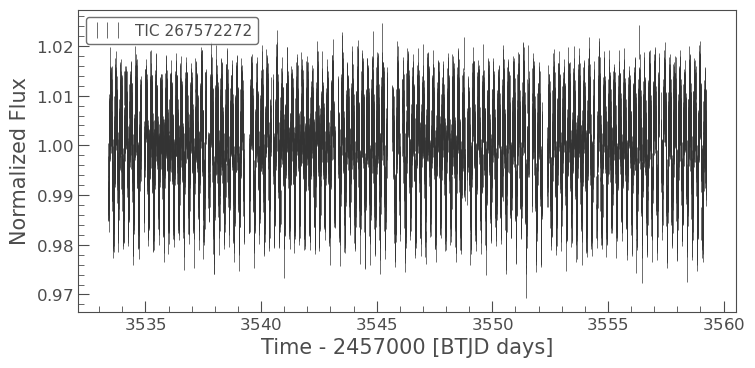

In [55]:
if runAsPython == False:
    flat_lc_no_transits.errorbar();

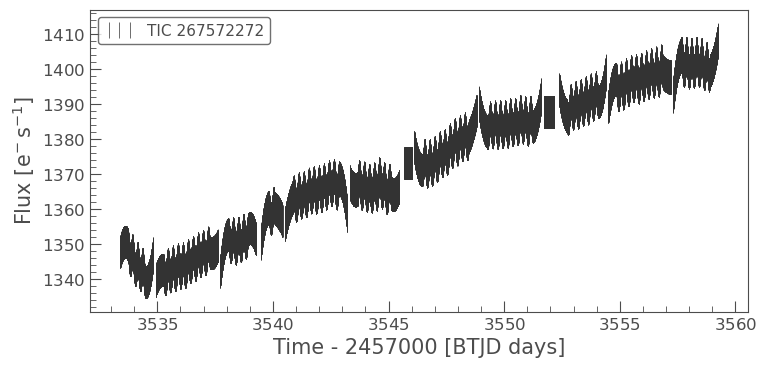

In [56]:
if runAsPython == False:
    trend_no_transits.errorbar();

In [57]:
print(mask_out_known_to_flatten_lc.keys())
print(flat_lc_no_transits.keys())

['time', 'flux', 'flux_err', 'centroid_col', 'centroid_row', 'cadenceno', 'quality']
['time', 'flux', 'flux_err', 'centroid_col', 'centroid_row', 'cadenceno', 'quality']


In [58]:
before_time = mask_out_known_to_flatten_lc.time
after_time = flat_lc_no_transits.time


In [59]:
xx = trend_no_transits.time.value
yy = trend_no_transits.flux.value
x_to_interp=[xx[0]]
y_to_interp=[yy[0]]

for ii in range(1,len(xx)):
    if yy[ii] != yy[-1]:
        x_to_interp.append(xx[ii])
        y_to_interp.append(yy[ii])
print("Started",len(xx),"Without repeated y vals",len(x_to_interp))

x_to_interp=np.array(x_to_interp)
y_to_interp=np.array(y_to_interp)

Started 17489 Without repeated y vals 17488


[3533.39453274 3533.39592161 3533.39731049 ... 3559.24277237 3559.24416124
 3559.2455501 ]
[1347.68347168 1347.72192383 1347.76013184 ... 1408.25415039 1408.3112793
 1408.36853027]


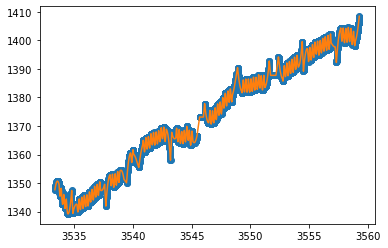

In [60]:
x = x_to_interp
y = y_to_interp
f = interpolate.interp1d(x, y, fill_value='extrapolate')

xnew = masked_lc.time.value
print(x)
print(y)
print(f)
ynew = f(xnew)   # use interpolation function returned by `interp1d`
if runAsPython == False:
    plt.plot(x, y, 'o', xnew, ynew, '-')

In [61]:
before_flux = mask_out_known_to_flatten_lc.flux
after_flux = flat_lc_no_transits.flux
print(after_flux, before_flux)

[0.98815857 0.99708311 0.99043344 ... 0.99101855 0.99712551 0.9964827 ] [1331.725  1343.7908 1334.8667 ... 1395.6626 1404.3202 1403.472 ] electron / s


### Interpolate the masking function

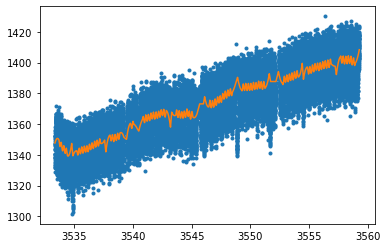

In [62]:
if runAsPython == False:
    plt.plot(masked_lc.time.value, masked_lc.flux.value, marker='.', ls='')
    plt.plot(xnew, ynew)

In [63]:
print(masked_lc.flux.value)
print(masked_lc.flux_err.value)

[1331.725  1343.7908 1334.8667 ... 1395.6626 1404.3202 1403.472 ]
[4.547093  4.56998   4.5558805 ... 4.648207  4.6522493 4.652987 ]


In [64]:
detrended_lc = masked_lc.flux.value/ynew
detrended_time = masked_lc.time.value
detrended_error = masked_lc.flux_err.value/np.median(ynew)

In [65]:
print(detrended_lc)
print(detrended_time)
print(detrended_error)

[0.98815857 0.99708311 0.99043344 ... 0.99101855 0.99712551 0.99648279]
[3533.39453274 3533.39592161 3533.39731049 ... 3559.24416124 3559.2455501
 3559.24693896]
[0.0033115  0.00332817 0.0033179  ... 0.00338514 0.00338808 0.00338862]


### FINAL light curve use this one for output

In [66]:
if use_planet == "CoRoT-14b":
    use_lc = masked_lc
    median = np.median(use_lc.flux.value)
    detrended_lc = use_lc.flux.value / median
    detrended_time = use_lc.time.value
    detrended_error = use_lc.flux_err.value/median
else:
    use_lc = masked_lc

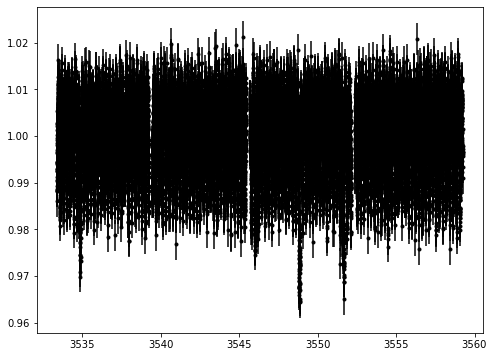

In [67]:
fig=plt.figure(figsize=(8,6),facecolor='white')
plt.errorbar(detrended_time, detrended_lc,yerr=detrended_error,ls="", color="k", marker='.');
#plt.savefig(plot_file, dpi=150, bbox_inches='tight')


### If there's any uncertainty about the period, check here

/Users/era/Documents/GitHub/Doomed-Worlds/Results-by-planet/HAT-P-37b/TESS/lomb_scargle_TESS-Sector-82.png
[3.86811189e-03 1.16043357e-02 1.93405595e-02 ... 1.75388316e+03
 1.75389090e+03 1.75389864e+03]


/opt/anaconda3/lib/python3.9/site-packages/astropy/timeseries/periodograms/lombscargle/_statistics.py:251: RuntimeWarning: invalid value encountered in sqrt
  return _gamma(NH) * W * (1 - Z) ** (0.5 * (NK - 1)) * np.sqrt(0.5 * NH * Z)


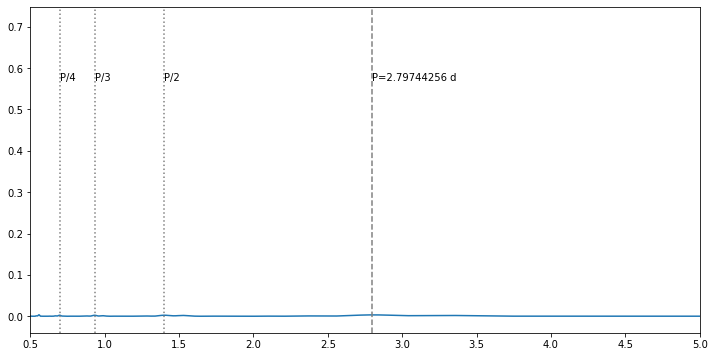

In [77]:
check_ls = True

min_per = 0.5
max_per = 5.0 #days

if check_ls:
    fileName=output_dir+"lomb_scargle_"+chunk_suffix+".png"
    print(fileName)

    fig = plt.figure(figsize=(12,6))
    ls = LombScargle(detrended_time, detrended_lc)#, midtime_err)
    frequency, power = ls.autopower()
    faps = ls.false_alarm_probability(power)
    print(frequency)
    corr_periods = 1 / frequency

    ax = fig.add_subplot(111)
    ax.plot(corr_periods, power)
    ax.set_xlim(min_per, max_per)
    ax.axvline(known_period[use_planet],ls="--",color="grey")
    ax.text(known_period[use_planet], 0.8*max(power),"P="+str(known_period[use_planet])+" d")
    # Show some aliases
    ax.axvline(known_period[use_planet]/2.,ls=":",color="grey")
    ax.text(known_period[use_planet]/2, 0.8*max(power),"P/2")
    ax.axvline(known_period[use_planet]/4.,ls=":",color="grey")
    ax.text(known_period[use_planet]/4, 0.8*max(power),"P/4")
    ax.axvline(known_period[use_planet]/3.,ls=":",color="grey")
    ax.text(known_period[use_planet]/3, 0.8*max(power),"P/3")
#    ax.axvline(known_period[use_planet]*5/6.,ls=":",color="grey")
#    ax.text(known_period[use_planet]*5/6, 0.8*max(power),"5/6 P")
    plt.savefig(fileName, dpi=150, bbox_inches='tight')


In [69]:
if check_ls:
    ### Want max power in our study range
    use_ii = []
    for ii,pp in enumerate(corr_periods):
        if pp <= max_per:
            use_ii.append(ii)
    use_power = power[use_ii]
    use_corr_periods = corr_periods[use_ii]
    print(len(use_corr_periods), len(corr_periods))
    

226687 226713


In [70]:
print(corr_periods)

[2.58524062e+02 8.61746874e+01 5.17048124e+01 ... 5.70163407e-04
 5.70160892e-04 5.70158377e-04]


In [71]:
# What happened to CoRoT-21b ???


Best known period for planet: HAT-P-37b 2.79744256


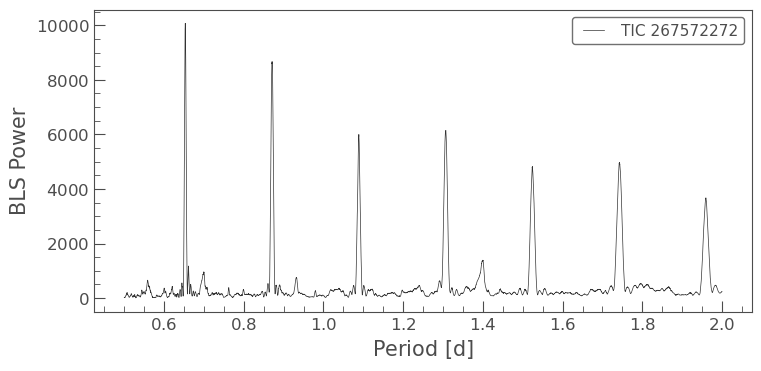

In [72]:
period_grid = np.linspace(0.5, 2, 10000)
print("Best known period for planet:",use_planet,known_period[use_planet])
bls = masked_lc.to_periodogram(method='bls', period=period_grid, frequency_factor=500);
bls.plot();


In [73]:
planet_b_period = bls.period_at_max_power
planet_b_t0 = bls.transit_time_at_max_power
planet_b_dur = bls.duration_at_max_power

# Check the value for period
print("BLS period",planet_b_period,"known",known_period[use_planet])


BLS period 0.6531653165316532 d known 2.79744256


Folded to BEST BLS period: 0.6531653165316532 d


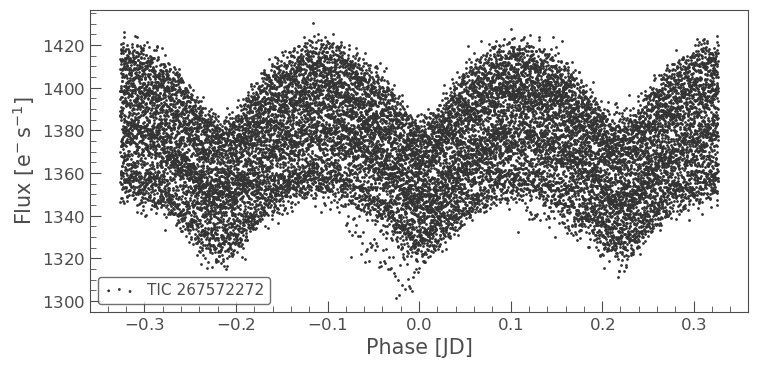

In [93]:
print("Folded to BEST BLS period:",planet_b_period)
ax = masked_lc.fold(period=planet_b_period, epoch_time=planet_b_t0).scatter();

Folded to KNOWN PLANET period: 2.79744256


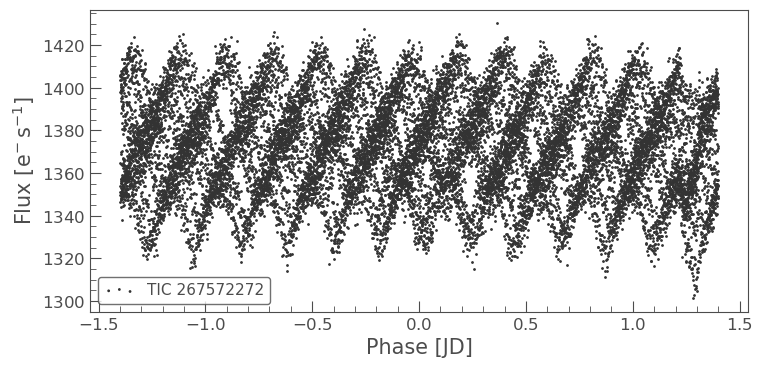

In [94]:
print("Folded to KNOWN PLANET period:",known_period[use_planet])
ax = masked_lc.fold(period=known_period[use_planet], epoch_time=planet_b_t0).scatter();

Folded to: 0.6531653165316532 d


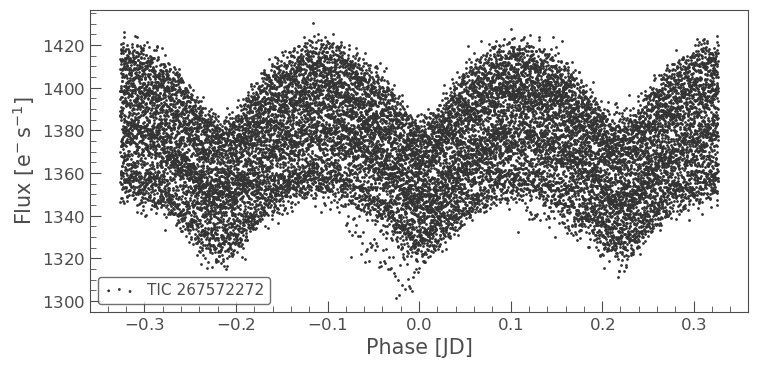

In [96]:
print("Folded to:",planet_b_period)
ax = masked_lc.fold(period=planet_b_period, epoch_time=planet_b_t0).scatter();
#ax.set_xlim(-5, 5);


### Output folded light curve so you can fit for a sector (or quarter) time

In [97]:
# Following Vissapgrada with Kepler-1658b, for low SNR transits we will stack
# Data is assigned to mid-sector
# "midquarter transit timings (defined to be the first transit after the midpoint of the quarter)"

In [98]:
known_ref_mid[use_planet]

2457938.84392

In [99]:
min_elapsed = num_elapsed_transits(min(detrended_time)+use_zero_time, known_period[use_planet], known_ref_mid[use_planet] )
mid_elapsed = num_elapsed_transits(np.median(detrended_time)+use_zero_time, known_period[use_planet], known_ref_mid[use_planet] )
max_elapsed = num_elapsed_transits(max(detrended_time)+use_zero_time, known_period[use_planet], known_ref_mid[use_planet] )
print("Transits elapsed since ref midtime to start of data series:", min_elapsed)
print("Transits elapsed since ref midtime to median time of data series:", mid_elapsed)
print("Transits elapsed since ref midtime to end of data series:  ", max_elapsed)

Transits elapsed since ref midtime to start of data series: 927
Transits elapsed since ref midtime to median time of data series: 932
Transits elapsed since ref midtime to end of data series:   937


In [100]:
midsector_time = predict_linear_eph(mid_elapsed, known_period[use_planet], known_ref_mid[use_planet] )
print("Assign midtime to:",midsector_time, midsector_time - use_zero_time)
assign_mid = midsector_time - use_zero_time

Assign midtime to: 2460546.06038592 3546.0603859201074


### Fold

In [101]:
def fold_lc_time(times, period, ref_mid, center_occ=False):
    if center_occ:
        rel_times = times - ref_mid  # to plot occultation in center
    else:
        rel_times = times - ref_mid - period/2. # to plot transit in center
    mod_rel_times = rel_times % period
    return mod_rel_times

In [102]:
print("Folding",use_planet,"to period",known_period[use_planet]," and ref mid", assign_mid)
folded_time = fold_lc_time(detrended_time, known_period[use_planet], assign_mid)

Folding HAT-P-37b to period 2.79744256  and ref mid 3546.0603859201074


In [103]:
def my_error_plot(time, flux, err):
    plt.errorbar(time, flux, yerr=err, ls="", color="k", marker='.', elinewidth=0.1,markersize=1)


In [104]:
bin_t1, bin_f1, bin_err1 = get_binned_flux_for_transit(folded_time, detrended_lc, nb=50,verbose=False)
bin_t2, bin_f2, bin_err2 = get_binned_flux_for_transit(folded_time, detrended_lc, nb=100,verbose=False)
bin_t3, bin_f3, bin_err3 = get_binned_flux_for_transit(folded_time, detrended_lc, nb=200,verbose=False)
bin_t4, bin_f4, bin_err = get_binned_flux_for_transit(folded_time, detrended_lc, nb=400,verbose=False)


/Users/era/Documents/GitHub/Doomed-Worlds/Results-by-planet/HAT-P-37b/folded_TESS-Sector-82_HAT-P-37b.png


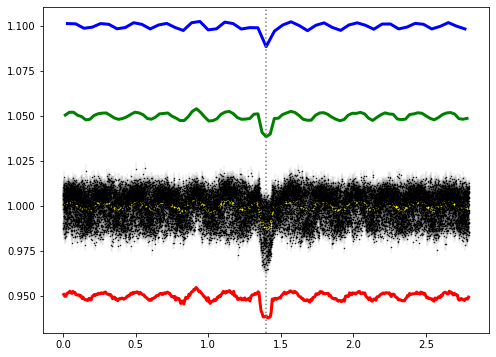

In [105]:
period = known_period[use_planet]

fig=plt.figure(figsize=(8,6),facecolor='white')
#plt.scatter(folded_time, detrended_lc, color="k", marker='.')
my_error_plot(folded_time, detrended_lc, detrended_error)
### ---> directory here if debugging
 # want centered not at edge
plt.plot(bin_t1,bin_f1+0.1,color="b",lw=3)   
plt.plot(bin_t2,bin_f2+0.05,color="g",lw=3)   
plt.plot(bin_t3,bin_f3,color="yellow",lw=3)   
plt.plot(bin_t4,bin_f4-0.05,color="r",lw=3)   


plt.axvline( known_period[use_planet]/2,ls=":",color="grey")

plot_file = use_dir + "folded_"+chunk_suffix+"_"+use_planet+".png"
print(plot_file)
plt.savefig(plot_file, dpi=150, bbox_inches='tight')


In [106]:
# translate back to the assigned midtime, so we can fit this
folded_times_assigned_mid_sector = (folded_time+assign_mid-known_period[use_planet]/2.)

In [107]:
print(min(folded_times_assigned_mid_sector), max(folded_times_assigned_mid_sector))
print("Assigned midtime:",assign_mid)

3544.6618276102213 3547.459102567883
Assigned midtime: 3546.0603859201074


In [108]:
### Output
mid_bjd_string = (Time(assign_mid+tess_zero_time, format='jd').isot).split("T")[0].replace("-","")
print(mid_bjd_string)

#sector_transit = use_planet +"_"+mid_bjd_string+"_"+chunk_suffix
sector_transit = use_planet +"_"+mid_bjd_string+"Stacked_"+chunk_suffix
print(sector_transit)
sector_transit_dir = use_dir+sector_transit+"/"


20240823
HAT-P-37b_20240823Stacked_TESS-Sector-82


In [109]:
### Need to sort
z = sorted(zip(folded_times_assigned_mid_sector + use_zero_time, detrended_lc, detrended_error))
sorted_folded_time, sorted_folded_flux, sorted_folded_flux_err = zip(*z)
print(sorted_folded_time[0])

2460544.6618276103


In [110]:
known_period[use_planet]
print("Assigned midtime:",assign_mid)
known_ref_mid[use_planet]

Assigned midtime: 3546.0603859201074


2457938.84392

In [111]:
################### Output stacked sector transit ########
transit = sector_transit
use_time = sorted_folded_time
use_flux = sorted_folded_flux
use_flux_err = sorted_folded_flux_err

transit_dir = use_dir+transit+"/"
if os.path.isdir(transit_dir) == False:
    os.makedirs(transit_dir)
transit_file = transit_dir + "transit_" + transit +".csv"
transit_file2 = planet_lit_dir + "transit_" + transit +".csv"
        
time_header = "Midtime_BJD" 
print(transit_file)
print(transit_file2)
print("#,Transit,"+transit,file=open(transit_file, "w"))
print("#,Exposure_times,['"+str(this_tess_sector_exp)+"']",file=open(transit_file, "a"))
print("#,Filter,['"+use_filter+"']",file=open(transit_file, "a"))
### Timing info for stacking
print("#,Folded_by_period,"+str(known_period[use_planet]),file=open(transit_file, "a"))
print("#,Ref_mid,"+str(known_ref_mid[use_planet]),file=open(transit_file, "a"))
print("#,Assigned_mid,"+str(assign_mid+tess_zero_time),file=open(transit_file, "a"))



print("Frame, "+time_header+", Flux_ratio, Norm_flux_ratio, Flux_err",file=open(transit_file, "a"))
for ii in range(len(use_time)):
    print(str(ii)+", "+ str(use_time[ii])+", "+  str(use_flux[ii])+", "+  str(use_flux[ii]) +", "+  str(use_flux_err[ii]),
          file=open(transit_file, "a"))
    
shutil.copy2(transit_file, transit_file2)

/Users/era/Documents/GitHub/Doomed-Worlds/Results-by-planet/HAT-P-37b/HAT-P-37b_20240823Stacked_TESS-Sector-82/transit_HAT-P-37b_20240823Stacked_TESS-Sector-82.csv
/Users/era/Documents/GitHub/Doomed-Worlds/Results-by-planet/HAT-P-37b/lit-curves/transit_HAT-P-37b_20240823Stacked_TESS-Sector-82.csv


'/Users/era/Documents/GitHub/Doomed-Worlds/Results-by-planet/HAT-P-37b/lit-curves/transit_HAT-P-37b_20240823Stacked_TESS-Sector-82.csv'

## Individual light curves

In [112]:
## XX We can easily extract individual light curves for toi-2109

In [47]:
chunk_bounds = []
use_ref_mid

938.8439199998975

In [48]:
## Note, we want the UNFOLDED time here
min_t = min(detrended_time)
max_t = max(detrended_time)
print("Min",min_t,"max",max_t)

NameError: name 'detrended_time' is not defined

In [115]:
def num_elapsed_transits(input_mid, ref_per, ref_mid ):
    """ How many transits is the input_mid since since the reference transit at ref_mid (using orbital ref_per). """
    n_elapsed = round((input_mid - ref_mid) / ref_per)
    return n_elapsed
def predict_linear_eph(ntr, period, ref_mid):
    """ A linear transit ephemeris. """
    return ref_mid + period * ntr


In [116]:
min_elapsed = num_elapsed_transits(min_t, known_period[use_planet], use_ref_mid )
max_elapsed = num_elapsed_transits(max_t, known_period[use_planet], use_ref_mid )
print("Transits elapsed since ref midtime to start of data series:", min_elapsed)
print("Transits elapsed since ref midtime to end of data series:  ", max_elapsed)

Transits elapsed since ref midtime to start of data series: 927
Transits elapsed since ref midtime to end of data series:   937


In [117]:
n_range = np.arange(min_elapsed-1,max_elapsed+2)
print(n_range)

[926 927 928 929 930 931 932 933 934 935 936 937 938]


In [118]:
pred_midtimes = predict_linear_eph(n_range, known_period[use_planet], use_ref_mid)
pred_chunk_start = pred_midtimes - known_period[use_planet]/2.
pred_chunk_end = pred_midtimes + known_period[use_planet]/2.


## OPTION: don't fit the whole window, just the bit near transit
## USE THIS if you have either (a) strong phase variability that won't flatten, or (b) occultations
if use_planet in ["NGTS-1b", "HATS-9b"]:
    only_do_transit = True
    amount_around_transit = 8/24. # 4 hours before and after, in days
elif use_planet in ["WASP-19b","TOI-2109b"]:
    only_do_transit = True
    amount_around_transit = 8/24. # 4 hours before and after, in days
else:
    only_do_transit = False
    amount_around_transit = known_period[use_planet]

if only_do_transit:
    print("Only take the central time:",amount_around_transit*24)
    pred_chunk_start = pred_midtimes - amount_around_transit/2.
    pred_chunk_end = pred_midtimes + amount_around_transit/2.


In [119]:
chunk_times= []
chunk_mids = []
for nn in range(len(pred_midtimes)):
    chunk_times.append( [pred_chunk_start[nn],pred_chunk_end[nn]] )
    utc_f = Time(pred_midtimes[nn]+use_zero_time,format="jd").isot
    chunk_utc = utc_f.split("T")[0].replace("-","")  + "-"+utc_f.split("T")[1].split(":")[0]
    chunk_mids.append(chunk_utc)

## Plot chunked up light curve

In [120]:
chunk_masks=[]
has_data_time =[]
has_data_lc =[]
has_data_err = []
has_data_names = []

for ii in range(len(chunk_times)):
    chunk_masks.append( (detrended_time >= chunk_times[ii][0]) & (detrended_time < chunk_times[ii][1]) )
    if(list(chunk_masks[ii]).count(True)>0):
        chunk_lc = detrended_lc[chunk_masks[ii]]
        chunk_lc_err = detrended_error[chunk_masks[ii]]
        chunk_time = detrended_time[chunk_masks[ii]]
        has_data_time.append(chunk_time)
        has_data_lc.append(chunk_lc)
        has_data_err.append(chunk_lc_err)
        has_data_names.append(use_planet + "_"+ chunk_mids[ii] +"_"+ chunk_suffix)

In [121]:
print(len(has_data_time))

11


In [122]:
#lc.time[436]

In [123]:
#for ii in range(len(has_data_time)):
#    print(min(has_data_time[ii])+use_zero_time)

## output to light curve for us to fit

In [124]:
print(len(has_data_names))
remake= True

11


In [125]:
if remake:
    make_ind_transits = True
    remake_plots = True
    remake_tables = True
else:
    make_ind_transits = False
    remake_plots = False
    remake_tables = False


HAT-P-37b_20240809-13_TESS-Sector-82
making /Users/era/Documents/GitHub/Doomed-Worlds/Results-by-planet/HAT-P-37b/HAT-P-37b_20240809-13_TESS-Sector-82/
HAT-P-37b_20240812-08_TESS-Sector-82
making /Users/era/Documents/GitHub/Doomed-Worlds/Results-by-planet/HAT-P-37b/HAT-P-37b_20240812-08_TESS-Sector-82/
HAT-P-37b_20240815-04_TESS-Sector-82
making /Users/era/Documents/GitHub/Doomed-Worlds/Results-by-planet/HAT-P-37b/HAT-P-37b_20240815-04_TESS-Sector-82/
HAT-P-37b_20240817-23_TESS-Sector-82
making /Users/era/Documents/GitHub/Doomed-Worlds/Results-by-planet/HAT-P-37b/HAT-P-37b_20240817-23_TESS-Sector-82/
HAT-P-37b_20240820-18_TESS-Sector-82
making /Users/era/Documents/GitHub/Doomed-Worlds/Results-by-planet/HAT-P-37b/HAT-P-37b_20240820-18_TESS-Sector-82/
HAT-P-37b_20240823-13_TESS-Sector-82
making /Users/era/Documents/GitHub/Doomed-Worlds/Results-by-planet/HAT-P-37b/HAT-P-37b_20240823-13_TESS-Sector-82/
HAT-P-37b_20240826-08_TESS-Sector-82
making /Users/era/Documents/GitHub/Doomed-Worlds/Re

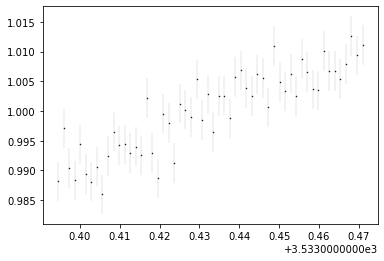

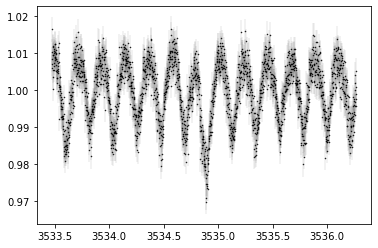

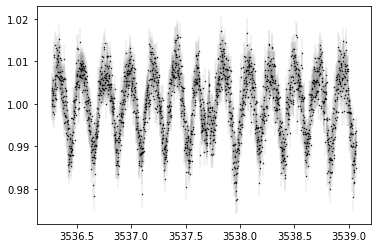

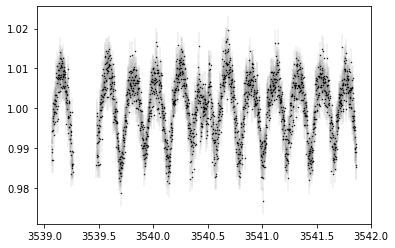

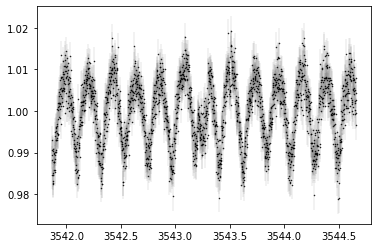

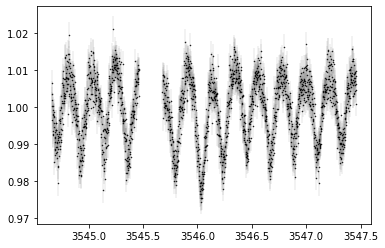

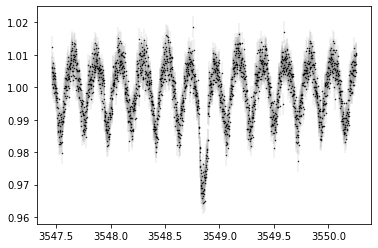

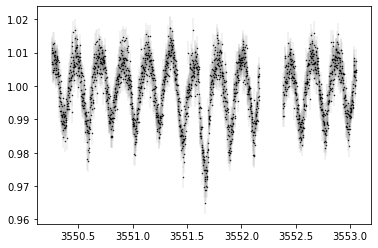

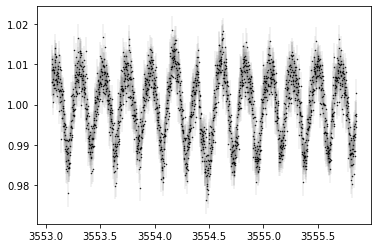

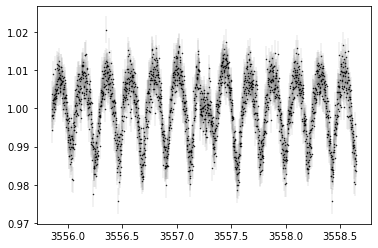

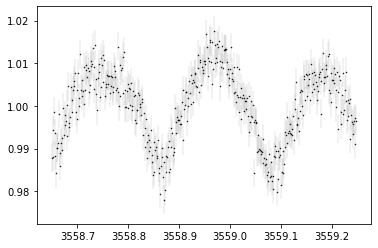

In [126]:
for nn,transit in enumerate(has_data_names):
    print(transit)
    transit_dir = use_dir+transit+"/"
    if os.path.isdir(transit_dir) == False:
        print("making",transit_dir)
        os.makedirs(transit_dir)
        
        
    ############
    if remake_plots:
        ## individual
        plot_file = transit_dir + "transit_"+transit+".png"
        plot_file2 = planet_lit_dir + "transit_"+transit+".png"
        fig=plt.figure(figsize=(6,4),facecolor='white')
       # plt.scatter(has_data_time[nn],has_data_lc[nn],color="k")
      #  my_error_plot(has_data_time[nn] + use_zero_time, has_data_lc[nn], has_data_err[nn])
        ### I think it's useful to display the time in the TESS units, but you can change that here
        my_error_plot(has_data_time[nn] , has_data_lc[nn], has_data_err[nn])

        #has_data[nn].errorbar();
        plt.savefig(plot_file, dpi=150, bbox_inches='tight')
            
        shutil.copy2(plot_file, plot_file2)    

In [127]:
remake_tables

True

In [128]:
if use_mission == "TESS":
    use_filter = "TESS"
elif use_mission in ["K2","Kepler"]:
    use_filter = "Kepler"

In [129]:
############ Now light curve files 

for nn, transit in enumerate(has_data_names):
    print(transit)

    if remake_tables:
        transit_dir = use_dir+transit+"/"

        transit_file = transit_dir + "transit_" + transit +".csv"
        transit_file2 = planet_lit_dir + "transit_" + transit +".csv"
        
        use_time = has_data_time[nn] + use_zero_time
        use_flux = has_data_lc[nn]
        use_flux_err = has_data_err[nn] # XC
        print("xxxxx",use_time[0], has_data_time[nn][0],has_data_lc[nn][0], has_data_err[nn][0] )
        
        time_header = "Midtime_BJD" 
        print(transit_file)
        print(transit_file2)
        print("#,Transit,"+transit,file=open(transit_file, "w"))
        print("#,Exposure_times,['"+str(this_tess_sector_exp)+"']",file=open(transit_file, "a"))
        print("#,Filter,['"+use_filter+"']",file=open(transit_file, "a"))
        print("Frame, "+time_header+", Flux_ratio, Norm_flux_ratio, Norm_flux_err",file=open(transit_file, "a"))
        for ii in range(len(use_time)):
            print(str(ii)+", "+ str(use_time[ii])+", "+  str(use_flux[ii])+", "+  str(use_flux[ii])+", "+  str(use_flux_err[ii]),
                  file=open(transit_file, "a"))
            
        shutil.copy2(transit_file, transit_file2)

HAT-P-37b_20240809-13_TESS-Sector-82
xxxxx 2460533.394532735 3533.3945327351703 0.9881585725215877 0.0033115011
/Users/era/Documents/GitHub/Doomed-Worlds/Results-by-planet/HAT-P-37b/HAT-P-37b_20240809-13_TESS-Sector-82/transit_HAT-P-37b_20240809-13_TESS-Sector-82.csv
/Users/era/Documents/GitHub/Doomed-Worlds/Results-by-planet/HAT-P-37b/lit-curves/transit_HAT-P-37b_20240809-13_TESS-Sector-82.csv
HAT-P-37b_20240812-08_TESS-Sector-82
xxxxx 2460533.472309802 3533.472309802152 1.010279486572948 0.0033453207
/Users/era/Documents/GitHub/Doomed-Worlds/Results-by-planet/HAT-P-37b/HAT-P-37b_20240812-08_TESS-Sector-82/transit_HAT-P-37b_20240812-08_TESS-Sector-82.csv
/Users/era/Documents/GitHub/Doomed-Worlds/Results-by-planet/HAT-P-37b/lit-curves/transit_HAT-P-37b_20240812-08_TESS-Sector-82.csv
HAT-P-37b_20240815-04_TESS-Sector-82
xxxxx 2460536.26949993 3536.269499930221 1.0008112807627274 0.0033352643
/Users/era/Documents/GitHub/Doomed-Worlds/Results-by-planet/HAT-P-37b/HAT-P-37b_20240815-04_TESS

## Now output a status file to update in the lit curves directory

In [130]:
lit_status_file = planet_lit_dir + "status_for_fitting_"+use_planet+".csv"
print(lit_status_file)

lit_status={}; lit_notes={}
for nn,transit in enumerate(has_data_names):
    lit_status[transit] = "True"
    lit_notes[transit] = ""

all_possible = []    
if os.path.isfile(lit_status_file):
    status_file_data = Table.read(lit_status_file, format='ascii.csv')
    status_file_transit = status_file_data['Transit']
    status_file_use = status_file_data["Use"]
    status_file_notes = status_file_data["Notes"]
   # print(status_file_notes.mask)
    
    for ii,tt in enumerate(status_file_transit):
        lit_status[tt] = status_file_use[ii]
        if status_file_notes.mask[ii]:
            lit_notes[tt] = ""
        else:
            lit_notes[tt] = status_file_notes[ii]

    all_possible = sorted(list(set(list(has_data_names)+list(status_file_transit))))
    print("All possible:", len(all_possible))
else:
    print(lit_status_file,"doesn't exist yet")
    all_possible = sorted(list(set(list(has_data_names))))

/Users/era/Documents/GitHub/Doomed-Worlds/Results-by-planet/HAT-P-37b/lit-curves/status_for_fitting_HAT-P-37b.csv
/Users/era/Documents/GitHub/Doomed-Worlds/Results-by-planet/HAT-P-37b/lit-curves/status_for_fitting_HAT-P-37b.csv doesn't exist yet


In [131]:
#lit_notes
print(len(all_possible))

11


In [132]:
print("Transit, Use, Notes",file=open(lit_status_file,"w"))
for nn,transit in enumerate(all_possible):
    print(transit+","+lit_status[transit]+","+lit_notes[transit],file=open(lit_status_file,"a"))

# Output occultations if observed

In [133]:
unsmoothed_time

array([3533.39453274, 3533.39592161, 3533.39731049, ..., 3559.24416124,
       3559.2455501 , 3559.24693896])

In [134]:
output_occultations = False
if use_planet in ["TOI-2109b"]:
    output_occultations = True
    use_time_for_occ = unsmoothed_time + use_zero_time
    use_flux_for_occ = phased_unsmoothed_flux_norm

In [135]:
if output_occultations:
    print("Folding",use_planet,"for occultations using period",known_period[use_planet]," and ref mid", assign_mid)
    folded_time_occ = fold_lc_time(use_time_for_occ, known_period[use_planet], assign_mid, center_occ=True)
    
    bin_t1o, bin_f1o, bin_err1o = get_binned_flux_for_transit(folded_time_occ, use_flux_for_occ, nb=50,verbose=False)
    bin_t2o, bin_f2o, bin_err2o = get_binned_flux_for_transit(folded_time_occ, use_flux_for_occ, nb=100,verbose=False)
    bin_t3o, bin_f3o, bin_err3o = get_binned_flux_for_transit(folded_time_occ, use_flux_for_occ, nb=200,verbose=False)
    bin_t4o, bin_f4o, bin_err4o = get_binned_flux_for_transit(folded_time_occ, use_flux_for_occ, nb=400,verbose=False)


In [136]:
if output_occultations:
    period = known_period[use_planet]

    fig=plt.figure(figsize=(8,6),facecolor='white')
    #plt.scatter(folded_time, detrended_lc, color="k", marker='.')
    my_error_plot(folded_time_occ, use_flux_for_occ, detrended_error)
    ### ---> directory here if debugging
     # want centered not at edge
    plt.plot(bin_t1o,bin_f1o+0.025,color="b",lw=3)   
    plt.plot(bin_t2o,bin_f2o+0.0125,color="g",lw=3)   
    plt.plot(bin_t3o,bin_f3o,color="yellow",lw=3)   
    plt.plot(bin_t4o,bin_f4o-0.0125,color="r",lw=3)   


    plt.axvline( known_period[use_planet]/2,ls=":",color="grey")

    plot_file = use_dir + "folded_for_occ_"+chunk_suffix+"_"+use_planet+".png"
    print(plot_file)
    plt.savefig(plot_file, dpi=150, bbox_inches='tight')


In [137]:
if output_occultations:
    # translate back to the assigned midtime, so we can fit this
    folded_times_assigned_mid_sector_occ = (folded_time_occ+assign_mid-known_period[use_planet]/2.)
    
    ### Need to sort
    z = sorted(zip(folded_times_assigned_mid_sector_occ + use_zero_time, use_flux_for_occ, detrended_error))
    sorted_folded_time_occ, sorted_folded_flux_occ, sorted_folded_flux_err_occ = zip(*z)
    print(sorted_folded_time_occ[0])

In [138]:
if output_occultations:
    use_ref_mid_occ = use_ref_mid + known_period[use_planet]/2.
    min_elapsed_occ = num_elapsed_transits(min_t, known_period[use_planet], use_ref_mid_occ )
    max_elapsed_occ = num_elapsed_transits(max_t, known_period[use_planet], use_ref_mid_occ )
    print("Occultations elapsed since ref midtime to start of data series:", min_elapsed)
    print("Occultations elapsed since ref midtime to end of data series:  ", max_elapsed)
    n_range = np.arange(min_elapsed_occ-1,max_elapsed_occ+2)


In [139]:
if output_occultations:
    pred_occtimes = predict_linear_eph(n_range, known_period[use_planet], use_ref_mid_occ)
    pred_chunk_start = pred_occtimes - known_period[use_planet]/2.
    pred_chunk_end = pred_occtimes + known_period[use_planet]/2.


    ## OPTION: don't fit the whole window, just the bit near transit
    ## USE THIS if you have either (a) strong phase variability that won't flatten, or (b) occultations
    if use_planet in ["NGTS-1b", "HATS-9b", "WASP-19b","TOI-2109b"]:
        only_do_occ = True
        amount_around_occ = 8/24. # 4 hours before and after, in days
    else:
        only_do_occ = False
        amount_around_occ = known_period[use_planet]

    if only_do_occ:
        print("Only take the central time:",amount_around_occ*24)
        pred_chunk_start_occ = pred_occtimes - amount_around_occ/2.
        pred_chunk_end_occ = pred_occtimes + amount_around_occ/2.

        
    chunk_times_occ= []
    chunk_mids_occ = []
    for nn in range(len(pred_occtimes)):
        chunk_times_occ.append( [pred_chunk_start_occ[nn], pred_chunk_end_occ[nn]] )
        utc_f = Time(pred_occtimes[nn]+use_zero_time,format="jd").isot
        chunk_utc = utc_f.split("T")[0].replace("-","")  + "-"+utc_f.split("T")[1].split(":")[0]
        chunk_mids_occ.append(chunk_utc)   

In [140]:
if output_occultations:
    chunk_masks_occ=[]
    has_data_time_occ =[]
    has_data_lc_occ =[]
    has_data_err_occ = []
    has_data_names_occ = []

    for ii in range(len(chunk_times_occ)):
        chunk_masks_occ.append( (detrended_time >= chunk_times_occ[ii][0]) & (detrended_time < chunk_times_occ[ii][1]) )
        if(list(chunk_masks_occ[ii]).count(True)>0):
            chunk_lc_occ = detrended_lc[chunk_masks_occ[ii]]
            chunk_lc_err_occ = detrended_error[chunk_masks_occ[ii]]
            chunk_time_occ = detrended_time[chunk_masks_occ[ii]]
            has_data_time_occ.append(chunk_time_occ)
            has_data_lc_occ.append(chunk_lc_occ)
            has_data_err_occ.append(chunk_lc_err_occ)
            has_data_names_occ.append(use_planet + "_"+ chunk_mids_occ[ii] +"_"+ chunk_suffix)

In [141]:
if output_occultations:

    for nn,occ in enumerate(has_data_names_occ):
        print(occ)
#        occ_dir = use_dir+"/Occultation_timing/"+occ+"/"
        occ_dir = use_dir+"/Occultation_timing/ind-occs/"
        if os.path.isdir(occ_dir) == False:
            print("making",occ_dir)
            os.makedirs(occ_dir)


        ############
        if remake_plots:
            ## individual
            plot_file = occ_dir + "occ_"+occ+".png"
            fig=plt.figure(figsize=(6,4),facecolor='white')
           # plt.scatter(has_data_time[nn],has_data_lc[nn],color="k")
          #  my_error_plot(has_data_time[nn] + use_zero_time, has_data_lc[nn], has_data_err[nn])
            ### I think it's useful to display the time in the TESS units, but you can change that here
            my_error_plot(has_data_time_occ[nn] , has_data_lc_occ[nn], has_data_err_occ[nn])

            #has_data[nn].errorbar();
            plt.savefig(plot_file, dpi=150, bbox_inches='tight')



In [142]:
sector_transit

'HAT-P-37b_20240823Stacked_TESS-Sector-82'

In [143]:
### Output the light curve BEFORE folding and smoothing

#phased_unsmoothed_time
#phased_unsmoothed_flux_norm

#assign_mid_occ

#unsmoothed_time

In [144]:
if output_occultations:
    ################### Output stacked sector transit ########
    occ = sector_transit+"-Occ"
    use_time = sorted_folded_time_occ
    use_flux = sorted_folded_flux_occ
    use_flux_err = sorted_folded_flux_err_occ

    occ_dir = use_dir+"/Occultation_timing/"+occ+"/"
    if os.path.isdir(occ_dir) == False:
        os.makedirs(occ_dir)
    occ_file = occ_dir + "occ_" + occ +".csv"

    time_header = "Midtime_BJD" 
    print(occ_file)
    print("#,Occultation,"+occ,file=open(occ_file, "w"))
    print("#,Exposure_times,['"+str(this_tess_sector_exp)+"']",file=open(occ_file, "a"))
    print("#,Filter,['"+use_filter+"']",file=open(occ_file, "a"))
    ### Timing info for stacking
    print("#,Folded_by_period,"+str(known_period[use_planet]),file=open(occ_file, "a"))
    print("#,Ref_mid,"+str(known_ref_mid[use_planet]),file=open(occ_file, "a"))
    print("#,Assigned_mid,"+str(assign_mid+tess_zero_time),file=open(occ_file, "a"))



    print("Frame, "+time_header+", Flux_ratio, Norm_flux_ratio, Flux_err",file=open(occ_file, "a"))
    for ii in range(len(use_time)):
        print(str(ii)+", "+ str(use_time[ii])+", "+  str(use_flux[ii])+", "+  str(use_flux[ii]) +", "+  str(use_flux_err[ii]),
              file=open(occ_file, "a"))

        

In [145]:
if output_occultations:
    plot_file = occ_file.replace("csv","png")
    fig=plt.figure(figsize=(18,6),facecolor='white')
    plt.errorbar(use_time, use_flux, yerr= None,
                 ls="", color="k", marker='.',markersize=1);

    bin_t, bin_f, bin_err = get_binned_flux_for_transit(use_time, use_flux,
                                                    nb=400,verbose=False)

    plt.errorbar(bin_t, bin_f, yerr= None,
             ls="-", color="r", marker='.',markersize=1);

    plt.title(use_planet+" occultations "+chunk_suffix)
    plt.ylim(0.98,1.01)
    plt.xlabel("days")
    plt.ylabel("normalized flux")
    plt.savefig(plot_file, dpi=150, bbox_inches='tight')
    print(plot_file)

# All done

You may now fit the light curves in Step 3

In [146]:
print(use_planet,use_sector_ind, search_result.mission[use_sector_ind])

HAT-P-37b 21 TESS Sector 82
